# Amazon Review Analysis (Summaries, Pros/Cons, Demographics)

## Imports

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import re
from sklearn.model_selection import train_test_split as tts
import torch
import collections 
from collections import Counter
from torch import nn
from torch.utils.data import Dataset, DataLoader
import spacy
import joblib
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aditya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing

In [2]:
df = pd.read_csv('Reviews.csv', nrows = 10000)
data = df[['Text', 'Summary']]
data.drop_duplicates(subset=['Text'], inplace=True) # Drop duplicate rows

In [3]:
word_mapping = {"ain't": "is not","aint": "is not", "aren't": "are not","arent": "are not","can't": "cannot","cant": "cannot", "'cause": "because", "cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 'mstake':"mistake",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not",'wasnt':"was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have", 'youve':"you have", 'goin':"going", '4ward':"forward", "shant":"shall not",'tat':"that", 'u':"you", 'v': "we",'b4':'before', "sayin'":"saying"
                      }

stop_words = set(stopwords.words('english'))
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([word_mapping[t] if t in word_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i) 
    text = " ".join(long_words).strip()
    def no_space(word, prev_word):
        return word in set(',!"";.''?') and prev_word!=" "
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text)]
    text = ''.join(out)
    return text

In [4]:
data['cleaned_text'] = data['Text'].apply(text_cleaner)
data['cleaned_summary'] = data['Summary'].apply(text_cleaner)
# this step is to remove all rows that have a blank summary
data["cleaned_summary"].replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)

In [5]:
max_len_text=200 
max_len_summary=10

In [6]:
x_train,x_test,y_train,y_test = tts(data['cleaned_text'],data['cleaned_summary'],test_size=0.1, shuffle=True, random_state=111)

In [7]:
# Tokenize function 
def tokenize(lines, token='word'):
    assert token in ('word', 'char'), 'Unknown token type: ' + token
    return [line.split() if token == 'word' else list(line) for line in lines]

# pading function
def truncate_pad(line, num_steps, padding_token):
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

# the vocabulary class 
class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']
# tokenize
src_tokens = tokenize(x_train)
tgt_tokens = tokenize(y_train)
# build vocabulary on dataset
src_vocab = Vocab(src_tokens, reserved_tokens=['<pad>', '<bos>', '<eos>'])
tgt_vocab = Vocab(tgt_tokens, reserved_tokens=['<pad>', '<bos>', '<eos>'])

In [8]:
# fn to add eos and padding and also determine valid length of each data sample
def build_array_sum(lines, vocab, num_steps):
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

src_array, src_valid_len = build_array_sum(src_tokens, src_vocab, max_len_text)
tgt_array, tgt_valid_len = build_array_sum(tgt_tokens, tgt_vocab, max_len_summary)
data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)

In [9]:
# create the tensor dataset object 
def load_array(data_arrays, batch_size, is_train=True):
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)
batch_size = 64
data_iter = load_array(data_arrays, batch_size)

## Transformer Architecture

In [10]:
# The main class 
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.w_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.w_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.w_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.w_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
    def forward(self, queries, keys, values, valid_lens):
        queries = transpose_qkv(self.w_q(queries), self.num_heads)
        keys = transpose_qkv(self.w_k(keys), self.num_heads)
        values = transpose_qkv(self.w_v(values), self.num_heads)
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats = self.num_heads, dim=0)
        output = self.attention(queries, keys, values, valid_lens)
        output_concat = transpose_output(output, self.num_heads)
        return self.w_o(output_concat)

# Function to transpose the linearly transformed query key and values 
def transpose_qkv(X, num_heads):
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

# For output formatting 
def transpose_output(X, num_heads):
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

# The dot product attention scoring function 
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2))/math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)
# Here masking is used so that irrelevant padding tokens are not considered
# while calculations

def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32)[None, :] < valid_len[:, None]    #device=X.device
    X[~mask] = value
    return X
# the irrelevant tokens are given a very small negative value which gets
# ignored in the subsequent calculations
def masked_softmax(X, valid_lens):
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1) 
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [11]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_output, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_output)
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1)/torch.pow(10000,torch.arange(0, num_hiddens,2, dtype=torch.float32)/num_hiddens)
        self.P[:,:, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
    
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [13]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout):
        super(AddNorm, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(X + self.dropout(Y))

In [14]:
# class for the block structure within 
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, 
                 ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens,num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

# the main encoder class
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias))
    
    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        self.attention_weights = [None]*len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [15]:
class DecoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None: # true when training the model
            key_values = X
        else:                        # while decoding state[2][self.i] is decoded output of the ith block till the present time-step
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps+1, device = X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

# The main decoder class 
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i), 
                                DecoderBlock(key_size, query_size, value_size,
                                             num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, i))
            self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None]*self.num_layers]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        self._attention_weights = [[None]*len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    def attention_weights(self):
        return self._attention_weights

In [16]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

In [17]:
def get_device(i=0):
    if torch.cuda.device_count() >= i+1:
        return torch.device(f'cuda:{i}')
    else:
        return torch.device('cpu')
device = get_device()

In [18]:
def initialize_weights(layers):
    if type(layers) == nn.Linear:
        nn.init.xavier_uniform_(layers.weight)
    if (type(layers) == nn.LSTM or type(layers) == nn.GRU):
        for param in layers._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(layers._parameters[param])

In [19]:
num_hiddens, num_layers, dropout, num_steps = 32, 2, 0.1, 10
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]
encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,num_layers, dropout)
net = Transformer(encoder, decoder)
net.apply(initialize_weights)  # initialize the weights

Transformer(
  (encoder): TransformerEncoder(
    (embedding): Embedding(16455, 32)
    (pos_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (blks): Sequential(
      (block0): EncoderBlock(
        (attention): MultiHeadAttention(
          (attention): DotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (w_q): Linear(in_features=32, out_features=32, bias=False)
          (w_k): Linear(in_features=32, out_features=32, bias=False)
          (w_v): Linear(in_features=32, out_features=32, bias=False)
          (w_o): Linear(in_features=32, out_features=32, bias=False)
        )
        (addnorm1): AddNorm(
          (dropout): Dropout(p=0.1, inplace=False)
          (ln): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (ffn): PositionWiseFFN(
          (dense1): Linear(in_features=32, out_features=64, bias=True)
          (relu): ReLU()
          (dense2): Linear(in_features=64, out

In [20]:
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [21]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [22]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

## Training

In [23]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):    
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    for epoch in range(num_epochs):
        metric = Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        print(f"Done with epoch number: {epoch+1}") # optional step
    print(f'loss {metric[0] / metric[1]:.3f} on {str(device)}')

In [24]:
lr = 0.005
num_epochs = 100

# Uncomment the line below to train the model
# train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device)

In [25]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,device, save_attention_weights=False):
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split()] + [src_vocab['<eos>']]
    src_tokens = [src_vocab[token] if token in src_vocab.token_to_idx else src_vocab['<unk>'] for token in src_sentence.lower().split()]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Unsqueeze adds another dimension that works as the the batch axis here
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis to the decoder now
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y = net.decoder(dec_X, dec_state)[0]
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
            # Once the end-of-sequence token is predicted, the generation of the output sequence is complete
        if pred == tgt_vocab['<eos>']:
                break
        output_seq.append(pred)
    if len(output_seq)<2:
        
        if len(output_seq)==1: 
            return ''.join(tgt_vocab.to_tokens(output_seq[0])), attention_weight_seq   
        else:
            
            return "No output!", attention_weight_seq
    else:
        return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

## Applying the Model

In [26]:
net = Transformer(encoder, decoder)
net.load_state_dict(torch.load("transformer_summarizer.pth", map_location=device))
net.to(device)
net.eval()

Transformer(
  (encoder): TransformerEncoder(
    (embedding): Embedding(16455, 32)
    (pos_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (blks): Sequential(
      (block0): EncoderBlock(
        (attention): MultiHeadAttention(
          (attention): DotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (w_q): Linear(in_features=32, out_features=32, bias=False)
          (w_k): Linear(in_features=32, out_features=32, bias=False)
          (w_v): Linear(in_features=32, out_features=32, bias=False)
          (w_o): Linear(in_features=32, out_features=32, bias=False)
        )
        (addnorm1): AddNorm(
          (dropout): Dropout(p=0.1, inplace=False)
          (ln): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (ffn): PositionWiseFFN(
          (dense1): Linear(in_features=32, out_features=64, bias=True)
          (relu): ReLU()
          (dense2): Linear(in_features=64, out

In [27]:
def summarize_product_reviews(product_id, df, net, src_vocab, tgt_vocab, num_steps, device):
    # Filter reviews for the given product ID
    reviews = df[df['ProductId'] == product_id]['Text'].dropna().tolist()
    if not reviews:
        return "No reviews found for this product ID."
    
    # Clean and concatenate all reviews into one string
    cleaned_reviews = [text_cleaner(review) for review in reviews]
    full_text = ' '.join(cleaned_reviews)
    
    # Summarize
    summary, _ = predict_seq2seq(net, full_text, src_vocab, tgt_vocab, num_steps, device)
    return summary

This product is popular among both males and females.


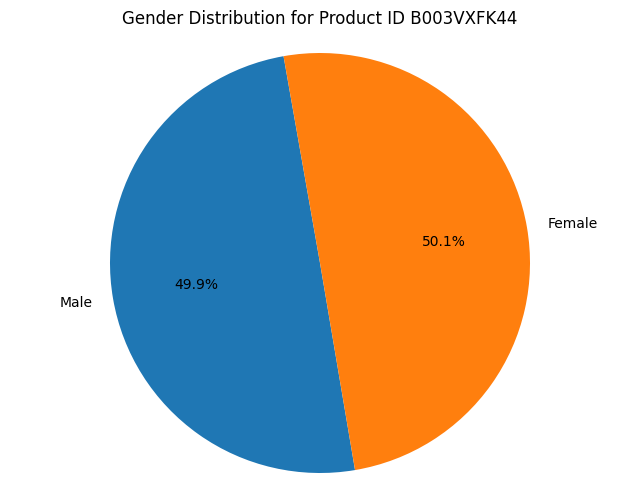


Top Pros:
    Pros  Mentions
favorite        15
  smooth        10
    nice         7
   yummy         5
   light         4

Top Cons:
     Cons  Mentions
     weak         7
   bitter         5
 horrible         3
defective         2
 terrible         2

Summary of Reviews:
good coffee brews hot


In [28]:
productId = "B003VXFK44" # Set the product ID you want to analyze

loaded_model = joblib.load('gender_predictor.pkl')
nlp = spacy.load('en_core_web_sm')
pros = {}
cons = {}

def analyze_review(review, rating):    
    # Extract adjectives (possible pros/cons)
    doc = nlp(review)
    excluded_words = ['good', 'bad', 'great', 'amazing', 'wonderful', 'best', 'many']
    aspects = [token.text.lower() for token in doc if token.pos_ == 'ADJ' and token.text.lower() not in excluded_words]

    # Positive Review
    if rating >= 4:
        for aspect in aspects:
            pros[aspect] = pros.get(aspect, 0) + 1
    # Negative review
    elif rating <= 2:
        for aspect in aspects:
            cons[aspect] = cons.get(aspect, 0) + 1
    
    return

def predict_gender(name):
    predicted_gender = loaded_model.predict([name.lower()])
    if predicted_gender[0] == 0:
        return('Male')
    else:
        return('Female')

# Extract Pros/Cons and Gender from each matching productId
df.loc[df['ProductId'] == productId, 'Extracted Aspects'] = df[df['ProductId'] == productId].apply(lambda row: analyze_review(row['Summary'], row['Score']), axis=1)
df.loc[df['ProductId'] == productId, 'Gender'] = df[df['ProductId'] == productId].apply(lambda row: predict_gender(row['ProfileName']), axis=1)

# Calculate gender proportion
num_reviews = len(df[(df['ProductId'] == productId)])
num_males = len(df[(df['ProductId'] == productId) & (df['Gender'] == 'Male')])
male_proportion = num_males / num_reviews

# Create DataFrames for Pros and Cons for visualization
top_pros = dict(sorted(pros.items(), key=lambda item: item[1], reverse=True)[:5])  # Top 5 Pros
top_cons = dict(sorted(cons.items(), key=lambda item: item[1], reverse=True)[:5])  # Top 5 Cons
pros_df = pd.DataFrame(list(top_pros.items()), columns=['Pros', 'Mentions'])
cons_df = pd.DataFrame(list(top_cons.items()), columns=['Cons', 'Mentions'])

# Output results
if male_proportion < 0.4:
    print('This product is most popular among females.')
elif male_proportion < 0.6:
    print('This product is popular among both males and females.')
else:
    print('This product is most popular among males')

# Pie chart data
labels = ['Male', 'Female']
sizes = [num_males, num_reviews-num_males]
colors = ['#1f77b4', '#ff7f0e']  # Blue for Male, Orange for Female

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=100)
plt.title('Gender Distribution for Product ID {}'.format(productId))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print('\nTop Pros:')
print(pros_df.to_string(index=False))

print('\nTop Cons:')
print(cons_df.to_string(index=False))

print('\nSummary of Reviews:')
print(summarize_product_reviews(productId, df, net, src_vocab, tgt_vocab, max_len_text, device))